# *(Wang, 2002)* Decision making spiking model

Implementation of the paper: *Wang, Xiao-Jing. "Probabilistic decision making by slow reverberation in cortical circuits." Neuron 36.5 (2002): 955-968.*

- Author : Chaoming Wang (chao.brain@qq.com)

In [1]:
import brainpy as bp
import brainpy.math as bm

bm.set_platform('cpu')
import matplotlib.pyplot as plt

## Neuron model

### LIF neurons

Both pyramidal cells and interneurons are described by leaky integrate-and-fire neurons. 

$$
C_{m} \frac{d V(t)}{d t}=-g_{L}\left(V(t)-V_{L}\right)-I_{s y n}(t)
$$

where 

- $I_{syn}(t)$ represents the total synaptic current flowing into the cell
- resting potential $V_L$ = -70 mV
- firing threshold $V_{th}$ = -50 mV
- reset potential $V_{rest}$ = -55 mV
- membrane capacitance $C_m$ = 0.5 nF for pyramidal cells and 0.2 nF for interneurons
- membrane leak conductance $g_L$ = 25 nS for pyramidal cells and 20 nS for interneurons
- refractory period $\tau_{ref}$ = 2 ms for pyramidal cells and 1 ms for interneurons

In [2]:
class LIF(bp.dyn.NeuGroup):
  def __init__(self, size, V_L=-70., V_reset=-55., V_th=-50.,
               Cm=0.5, gL=0.025, t_refractory=2., **kwargs):
    super(LIF, self).__init__(size=size, **kwargs)

    self.V_L = V_L
    self.V_reset = V_reset
    self.V_th = V_th
    self.Cm = Cm
    self.gL = gL
    self.t_refractory = t_refractory

    self.V = bm.Variable(bm.ones(self.num) * V_L)
    self.input = bm.Variable(bm.zeros(self.num))
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.refractory = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.t_last_spike = bm.Variable(bm.ones(self.num) * -1e7)

    self.integral = bp.odeint(self.derivative)

  def derivative(self, V, t):
    dVdt = (- self.gL * (V - self.V_L) + self.input) / self.Cm
    return dVdt

  def update(self, _t, _dt):
    ref = (_t - self.t_last_spike) <= self.t_refractory
    V = self.integral(self.V, _t, _dt)
    V = bm.where(ref, self.V, V)
    spike = (V >= self.V_th)
    self.V.value = bm.where(spike, self.V_reset, V)
    self.spike.value = spike
    self.t_last_spike.value = bm.where(spike, _t, self.t_last_spike)
    self.refractory.value = bm.logical_or(spike, ref)
    self.input[:] = 0.

### Poisson neurons

In [3]:
class PoissonStim(bp.dyn.NeuGroup):
  def __init__(self, size, freq_mean, freq_var, t_interval, **kwargs):
    super(PoissonStim, self).__init__(size=size, **kwargs)

    self.freq_mean = freq_mean
    self.freq_var = freq_var
    self.t_interval = t_interval
    self.dt = bm.get_dt() / 1000.

    self.freq = bm.Variable(bm.zeros(1))
    self.freq_t_last_change = bm.Variable(bm.ones(1) * -1e7)
    self.spike = bm.Variable(bm.zeros(self.num, dtype=bool))
    self.rng = bm.random.RandomState()

  def update(self, _t, _dt):
    in_interval = bm.logical_and(pre_stimulus_period < _t, _t < pre_stimulus_period + stimulus_period)
    prev_freq = bm.where(in_interval, self.freq[0], 0.)
    in_interval = bm.logical_and(in_interval, (_t - self.freq_t_last_change[0]) >= self.t_interval)
    self.freq[:] = bm.where(in_interval, self.rng.normal(self.freq_mean, self.freq_var), prev_freq)
    self.freq_t_last_change[:] = bm.where(in_interval, _t, self.freq_t_last_change[0])
    self.spike.value = self.rng.random(self.num) < self.freq[0] * self.dt

## Network model

In [4]:
class DecisionMaking(bp.dyn.Network):
  def __init__(self, scale=1., mu0=40., coherence=25.6, dt=0.1):
    super(DecisionMaking, self).__init__()

    f = 0.15
    num_exc = int(1600 * scale)
    num_inh = int(400 * scale)
    num_A = int(f * num_exc)
    num_B = int(f * num_exc)
    num_N = num_exc - num_A - num_B
    print(f'Total network size: {num_exc + num_inh}')

    poisson_freq = 2400.  # Hz
    w_pos = 1.7
    w_neg = 1. - f * (w_pos - 1.) / (1. - f)
    g_max_ext2E_AMPA = 2.1 * 1e-3  # uS
    g_max_ext2I_AMPA = 1.62 * 1e-3  # uS
    g_max_E2E_AMPA = 0.05 * 1e-3 / scale  # uS
    g_max_E2E_NMDA = 0.165 * 1e-3 / scale  # uS
    g_max_E2I_AMPA = 0.04 * 1e-3 / scale  # uS
    g_max_E2I_NMDA = 0.13 * 1e-3 / scale  # uS
    g_max_I2E_GABAa = 1.3 * 1e-3 / scale  # uS
    g_max_I2I_GABAa = 1.0 * 1e-3 / scale  # uS

    ampa_par = dict(delay_step=int(0.5 / dt), E=0., tau=2.0)
    gaba_par = dict(delay_step=int(0.5 / dt), E=-70., tau=5.0)
    nmda_par = dict(delay_step=int(0.5 / dt), tau_decay=100, tau_rise=2., E=0., cc_Mg=1., a=0.5)

    # E neurons/pyramid neurons
    A = LIF(num_A, Cm=0.5, gL=0.025, t_refractory=2.)
    B = LIF(num_B, Cm=0.5, gL=0.025, t_refractory=2.)
    N = LIF(num_N, Cm=0.5, gL=0.025, t_refractory=2.)

    # I neurons/interneurons
    I = LIF(num_inh, Cm=0.2, gL=0.020, t_refractory=1.)

    # poisson stimulus
    IA = PoissonStim(num_A, freq_var=10., t_interval=50., freq_mean=mu0 + mu0 / 100. * coherence)
    IB = PoissonStim(num_B, freq_var=10., t_interval=50., freq_mean=mu0 - mu0 / 100. * coherence)

    # noise neurons
    self.noise_A = bp.dyn.PoissonGroup(num_A, freqs=poisson_freq)
    self.noise_B = bp.dyn.PoissonGroup(num_B, freqs=poisson_freq)
    self.noise_N = bp.dyn.PoissonGroup(num_N, freqs=poisson_freq)
    self.noise_I = bp.dyn.PoissonGroup(num_inh, freqs=poisson_freq)

    # define external inputs
    self.IA2A = bp.dyn.ExpCOBA(IA, A, bp.conn.One2One(), g_max=g_max_ext2E_AMPA, **ampa_par)
    self.IB2B = bp.dyn.ExpCOBA(IB, B, bp.conn.One2One(), g_max=g_max_ext2E_AMPA, **ampa_par)

    # define E2E conn
    self.A2A_AMPA = bp.dyn.ExpCOBA(A, A, bp.conn.All2All(), g_max=g_max_E2E_AMPA * w_pos, **ampa_par)
    self.A2A_NMDA = bp.dyn.NMDA(A, A, bp.conn.All2All(), g_max=g_max_E2E_NMDA * w_pos, **nmda_par)

    self.A2B_AMPA = bp.dyn.ExpCOBA(A, B, bp.conn.All2All(), g_max=g_max_E2E_AMPA * w_neg, **ampa_par)
    self.A2B_NMDA = bp.dyn.NMDA(A, B, bp.conn.All2All(), g_max=g_max_E2E_NMDA * w_neg, **nmda_par)

    self.A2N_AMPA = bp.dyn.ExpCOBA(A, N, bp.conn.All2All(), g_max=g_max_E2E_AMPA, **ampa_par)
    self.A2N_NMDA = bp.dyn.NMDA(A, N, bp.conn.All2All(), g_max=g_max_E2E_NMDA, **nmda_par)

    self.B2A_AMPA = bp.dyn.ExpCOBA(B, A, bp.conn.All2All(), g_max=g_max_E2E_AMPA * w_neg)
    self.B2A_NMDA = bp.dyn.NMDA(B, A, bp.conn.All2All(), g_max=g_max_E2E_NMDA * w_neg, **nmda_par)

    self.B2B_AMPA = bp.dyn.ExpCOBA(B, B, bp.conn.All2All(), g_max=g_max_E2E_AMPA * w_pos, **ampa_par)
    self.B2B_NMDA = bp.dyn.NMDA(B, B, bp.conn.All2All(), g_max=g_max_E2E_NMDA * w_pos, **nmda_par)

    self.B2N_AMPA = bp.dyn.ExpCOBA(B, N, bp.conn.All2All(), g_max=g_max_E2E_AMPA, **ampa_par)
    self.B2N_NMDA = bp.dyn.NMDA(B, N, bp.conn.All2All(), g_max=g_max_E2E_NMDA, **nmda_par)

    self.N2A_AMPA = bp.dyn.ExpCOBA(N, A, bp.conn.All2All(), g_max=g_max_E2E_AMPA * w_neg, **ampa_par)
    self.N2A_NMDA = bp.dyn.NMDA(N, A, bp.conn.All2All(), g_max=g_max_E2E_NMDA * w_neg, **nmda_par)

    self.N2B_AMPA = bp.dyn.ExpCOBA(N, B, bp.conn.All2All(), g_max=g_max_E2E_AMPA * w_neg, **ampa_par)
    self.N2B_NMDA = bp.dyn.NMDA(N, B, bp.conn.All2All(), g_max=g_max_E2E_NMDA * w_neg, **nmda_par)

    self.N2N_AMPA = bp.dyn.ExpCOBA(N, N, bp.conn.All2All(), g_max=g_max_E2E_AMPA, **ampa_par)
    self.N2N_NMDA = bp.dyn.NMDA(N, N, bp.conn.All2All(), g_max=g_max_E2E_NMDA, **nmda_par)

    # define E2I conn
    self.A2I_AMPA = bp.dyn.ExpCOBA(A, I, bp.conn.All2All(), g_max=g_max_E2I_AMPA, **ampa_par)
    self.A2I_NMDA = bp.dyn.NMDA(A, I, bp.conn.All2All(), g_max=g_max_E2I_NMDA, **nmda_par)

    self.B2I_AMPA = bp.dyn.ExpCOBA(B, I, bp.conn.All2All(), g_max=g_max_E2I_AMPA, **ampa_par)
    self.B2I_NMDA = bp.dyn.NMDA(B, I, bp.conn.All2All(), g_max=g_max_E2I_NMDA, **nmda_par)

    self.N2I_AMPA = bp.dyn.ExpCOBA(N, I, bp.conn.All2All(), g_max=g_max_E2I_AMPA, **ampa_par)
    self.N2I_NMDA = bp.dyn.NMDA(N, I, bp.conn.All2All(), g_max=g_max_E2I_NMDA, **nmda_par)

    # define I2E conn
    self.I2A = bp.dyn.ExpCOBA(I, A, bp.conn.All2All(), g_max=g_max_I2E_GABAa, **gaba_par)
    self.I2B = bp.dyn.ExpCOBA(I, B, bp.conn.All2All(), g_max=g_max_I2E_GABAa, **gaba_par)
    self.I2N = bp.dyn.ExpCOBA(I, N, bp.conn.All2All(), g_max=g_max_I2E_GABAa, **gaba_par)

    # define I2I conn
    self.I2I = bp.dyn.ExpCOBA(I, I, bp.conn.All2All(), g_max=g_max_I2I_GABAa, **gaba_par)

    # define external projections
    self.noise2A = bp.dyn.ExpCOBA(self.noise_A, A, bp.conn.One2One(), g_max=g_max_ext2E_AMPA, **ampa_par)
    self.noise2B = bp.dyn.ExpCOBA(self.noise_B, B, bp.conn.One2One(), g_max=g_max_ext2E_AMPA, **ampa_par)
    self.noise2N = bp.dyn.ExpCOBA(self.noise_N, N, bp.conn.One2One(), g_max=g_max_ext2E_AMPA, **ampa_par)
    self.noise2I = bp.dyn.ExpCOBA(self.noise_I, I, bp.conn.One2One(), g_max=g_max_ext2I_AMPA, **ampa_par)

    # nodes
    self.A = A
    self.B = B
    self.N = N
    self.I = I
    self.IA = IA
    self.IB = IB

  def update(self, _t, _dt):
    nodes = self.nodes(level=1, include_self=False)
    nodes = nodes.subset(bp.dyn.DynamicalSystem).unique()
    for node in nodes.values():
      node.update(_t, _dt)

In [5]:
net = DecisionMaking(scale=1.)

Total network size: 2000


## Running

In [6]:
runner = bp.dyn.DSRunner(net,
                         monitors=['A.spike', 'B.spike', 'IA.freq', 'IB.freq'],
                         dyn_vars=net.vars().unique())
pre_stimulus_period = 100.
stimulus_period = 1000.
delay_period = 500.
total_period = pre_stimulus_period + stimulus_period + delay_period
t = runner(total_period)
print(f'Used time: {t} s')

  0%|          | 0/16000 [00:00<?, ?it/s]

Used time: 22.81012463569641 s


## Visualization

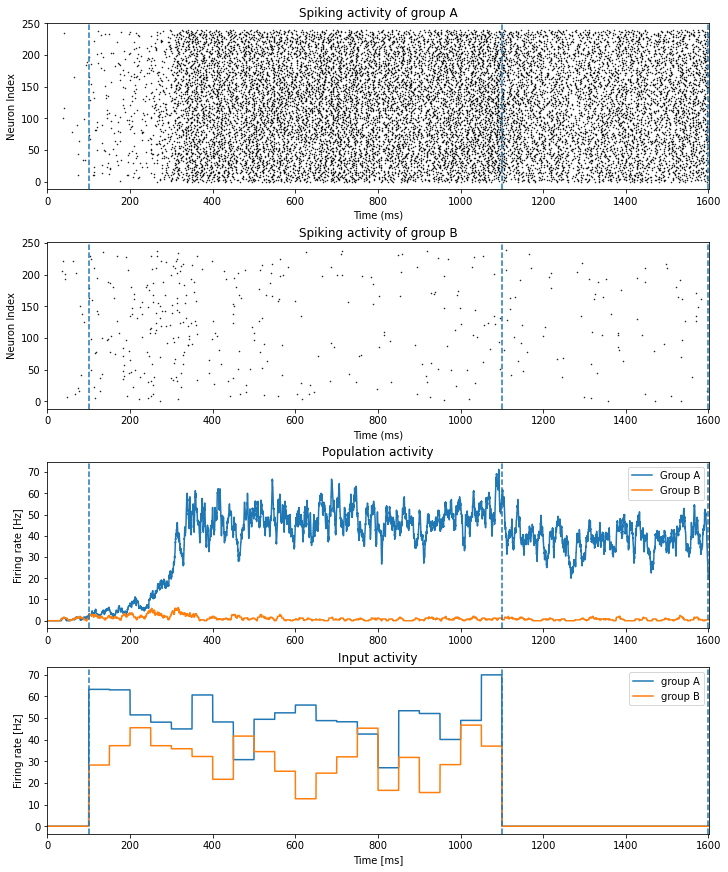

In [7]:
fig, gs = bp.visualize.get_figure(4, 1, 3, 10)

t_start = 0.
fig.add_subplot(gs[0, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['A.spike'], markersize=1)
plt.title("Spiking activity of group A")
plt.ylabel("Neuron Index")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period + delay_period, linestyle='dashed')

fig.add_subplot(gs[1, 0])
bp.visualize.raster_plot(runner.mon.ts, runner.mon['B.spike'], markersize=1)
plt.title("Spiking activity of group B")
plt.ylabel("Neuron Index")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period + delay_period, linestyle='dashed')

fig.add_subplot(gs[2, 0])
rateA = bp.measure.firing_rate(runner.mon['A.spike'], width=10.)
rateB = bp.measure.firing_rate(runner.mon['B.spike'], width=10.)
plt.plot(runner.mon.ts, rateA, label="Group A")
plt.plot(runner.mon.ts, rateB, label="Group B")
plt.ylabel('Firing rate [Hz]')
plt.title("Population activity")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period + delay_period, linestyle='dashed')
plt.legend()

fig.add_subplot(gs[3, 0])
plt.plot(runner.mon.ts, runner.mon['IA.freq'], label="group A")
plt.plot(runner.mon.ts, runner.mon['IB.freq'], label="group B")
plt.title("Input activity")
plt.ylabel("Firing rate [Hz]")
plt.xlim(t_start, total_period + 1)
plt.axvline(pre_stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period, linestyle='dashed')
plt.axvline(pre_stimulus_period + stimulus_period + delay_period, linestyle='dashed')
plt.legend()

plt.xlabel("Time [ms]")
plt.show()